In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import sys
sys.path.append('/gdrive/MyDrive/hw3')

In [ ]:
# --- imports ---
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils
torch.multiprocessing.set_start_method('spawn', force=True)

In [ ]:
# ---- utility functions -----
def get_loaders(batch_size,device):
    train_set = hw3utils.HW3ImageFolder('/gdrive/MyDrive/hw3/ceng483-hw3-dataset/train',device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder('/gdrive/MyDrive/hw3/ceng483-hw3-dataset/val',device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

In [ ]:
# 1 convolutional layer
class Net1(nn.Module):
    def __init__(self, num_kernels):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, padding=1)

    def forward(self, grayscale_image):
        x = self.conv1(grayscale_image)
        return x

In [ ]:
# 2 convolutional layers
class Net2(nn.Module):
    def __init__(self, num_kernels):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, num_kernels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_kernels, 3, 3, padding=1)

    def forward(self, grayscale_image):
        x = F.relu(self.conv1(grayscale_image))
        x = self.conv2(x)
        return x

In [ ]:
# 4 convolutional layers
class Net4(nn.Module):
    def __init__(self, num_kernels):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(1, num_kernels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_kernels, num_kernels, 3, padding=1)
        self.conv3 = nn.Conv2d(num_kernels, num_kernels, 3, padding=1)
        self.conv4 = nn.Conv2d(num_kernels, 3, 3, padding=1)

    def forward(self, grayscale_image):
        x = F.relu(self.conv1(grayscale_image))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [ ]:
def train_and_evaluate(net, train_loader, val_loader, lr, max_num_epoch, device, patience=3):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    train_losses, val_losses_x, val_losses_y, margin_errors, yy = [], [], [], [],[]
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_num_epoch):
        net.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        if (epoch + 1) % 5 == 0 or epoch == 0:
            net.eval()  # Evaluation mode
            val_loss, margin_error = 0.0, 0.0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = net(val_inputs)
                    val_loss += criterion(val_outputs, val_targets).item()
                    margin_error += (torch.abs(torch.sub(val_outputs, val_targets)) > 24.0/255.0).sum().to(dtype=torch.float) / float(val_outputs.reshape(-1).shape[0])

            val_losses_x.append(epoch)
            val_losses_y.append(val_loss / len(val_loader))
            margin_errors.append(margin_error / len(val_loader))
            yy.append(epoch)

            if val_losses_y[-1] < best_val_loss:
                best_val_loss = val_losses_y[-1]
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve == patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses_y[-1]:.4f}, 12-Margin Error: {margin_errors[-1]:.4f}, Accuracy: {1 - margin_errors[-1]:.4f}')
                break

            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses_y[-1]:.4f}, 12-Margin Error: {margin_errors[-1]:.4f}, Accuracy: {1 - margin_errors[-1]:.4f}')


    accuracies = [1 - x for x in margin_errors]


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses_x, val_losses_y, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(yy, margin_errors, label='12-Margin Error')
    plt.title('12-Margin Error over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(yy,accuracies, label='Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [ ]:
num_layers = [1,2,4]
num_kernels = [2,4,8]
learning_rate = [0.1, 0.01, 0.001]
batch_size = 16

In [ ]:
train_loader, val_loader = get_loaders(batch_size=16,device='cuda:0')

In [ ]:
device = 'cpu'

Epoch 1, Train Loss: 0.0147, Val Loss: 0.0096, 12-Margin Error: 0.2550, Accuracy: 0.7450
Epoch 5, Train Loss: 0.0091, Val Loss: 0.0097, 12-Margin Error: 0.2588, Accuracy: 0.7412
Epoch 10, Train Loss: 0.0091, Val Loss: 0.0091, 12-Margin Error: 0.2450, Accuracy: 0.7550
Epoch 15, Train Loss: 0.0091, Val Loss: 0.0091, 12-Margin Error: 0.2470, Accuracy: 0.7530
Epoch 20, Train Loss: 0.0091, Val Loss: 0.0091, 12-Margin Error: 0.2454, Accuracy: 0.7546
Early stopping triggered at epoch 25
Epoch 25, Train Loss: 0.0091, Val Loss: 0.0091, 12-Margin Error: 0.2466, Accuracy: 0.7534


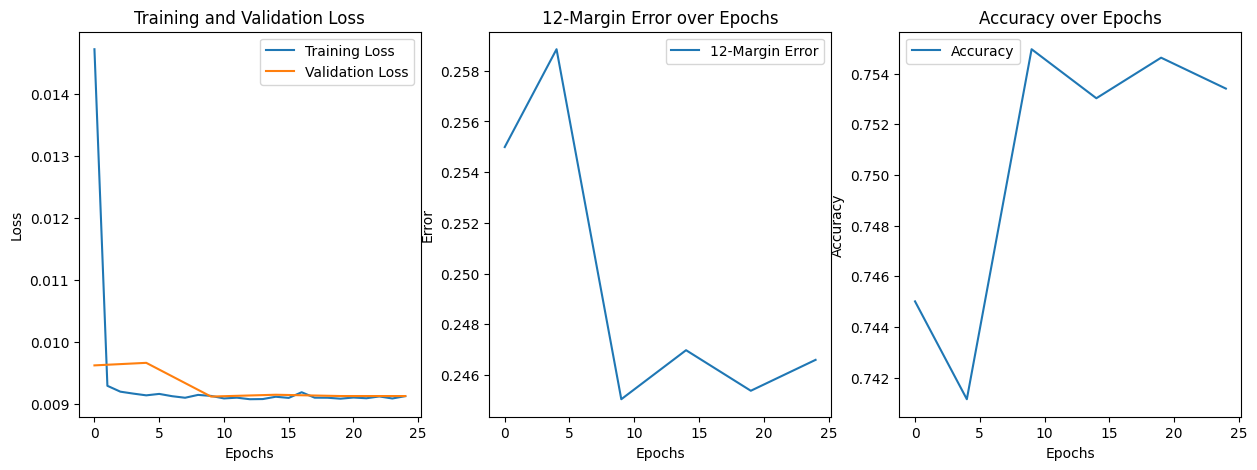

In [ ]:
net1 = Net1(2).to(device)
train_and_evaluate(net1, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0140, Val Loss: 0.0095, 12-Margin Error: 0.2539, Accuracy: 0.7461
Epoch 5, Train Loss: 0.0086, Val Loss: 0.0086, 12-Margin Error: 0.2350, Accuracy: 0.7650
Epoch 10, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2343, Accuracy: 0.7657
Epoch 15, Train Loss: 0.0085, Val Loss: 0.0085, 12-Margin Error: 0.2332, Accuracy: 0.7668
Epoch 20, Train Loss: 0.0085, Val Loss: 0.0087, 12-Margin Error: 0.2384, Accuracy: 0.7616
Epoch 25, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2353, Accuracy: 0.7647
Early stopping triggered at epoch 30
Epoch 30, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2341, Accuracy: 0.7659


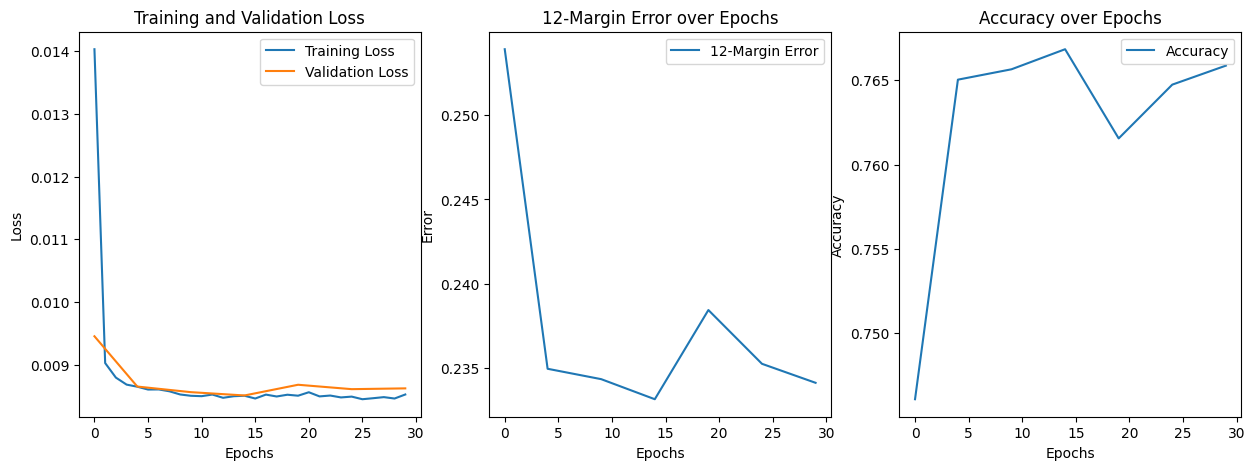

In [ ]:
net2 = Net2(2).to(device)
train_and_evaluate(net2, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.1310, Val Loss: 0.1276, 12-Margin Error: 0.7959, Accuracy: 0.2041
Epoch 5, Train Loss: 0.1306, Val Loss: 0.1271, 12-Margin Error: 0.7958, Accuracy: 0.2042
Epoch 10, Train Loss: 0.1305, Val Loss: 0.1271, 12-Margin Error: 0.7973, Accuracy: 0.2027
Epoch 15, Train Loss: 0.1309, Val Loss: 0.1270, 12-Margin Error: 0.7971, Accuracy: 0.2029
Epoch 20, Train Loss: 0.1309, Val Loss: 0.1271, 12-Margin Error: 0.7955, Accuracy: 0.2045
Epoch 25, Train Loss: 0.1305, Val Loss: 0.1278, 12-Margin Error: 0.7981, Accuracy: 0.2019
Early stopping triggered at epoch 30
Epoch 30, Train Loss: 0.1308, Val Loss: 0.1272, 12-Margin Error: 0.7961, Accuracy: 0.2039


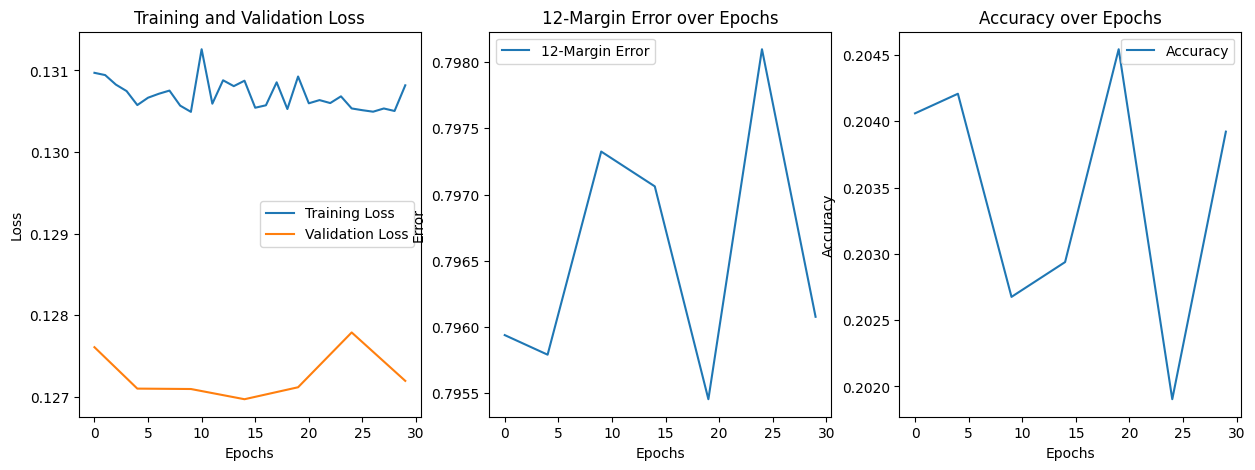

In [ ]:
net4 = Net4(2).to(device)
train_and_evaluate(net4, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0141, Val Loss: 0.0097, 12-Margin Error: 0.2612, Accuracy: 0.7388
Epoch 5, Train Loss: 0.0087, Val Loss: 0.0089, 12-Margin Error: 0.2470, Accuracy: 0.7530
Epoch 10, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2336, Accuracy: 0.7664
Epoch 15, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2346, Accuracy: 0.7654
Epoch 20, Train Loss: 0.0085, Val Loss: 0.0085, 12-Margin Error: 0.2319, Accuracy: 0.7681
Epoch 25, Train Loss: 0.0084, Val Loss: 0.0084, 12-Margin Error: 0.2307, Accuracy: 0.7693
Epoch 30, Train Loss: 0.0084, Val Loss: 0.0084, 12-Margin Error: 0.2308, Accuracy: 0.7692
Epoch 35, Train Loss: 0.0084, Val Loss: 0.0085, 12-Margin Error: 0.2314, Accuracy: 0.7686
Epoch 40, Train Loss: 0.0084, Val Loss: 0.0084, 12-Margin Error: 0.2291, Accuracy: 0.7709
Epoch 45, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2308, Accuracy: 0.7692
Epoch 50, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2319, Accuracy: 0.7681


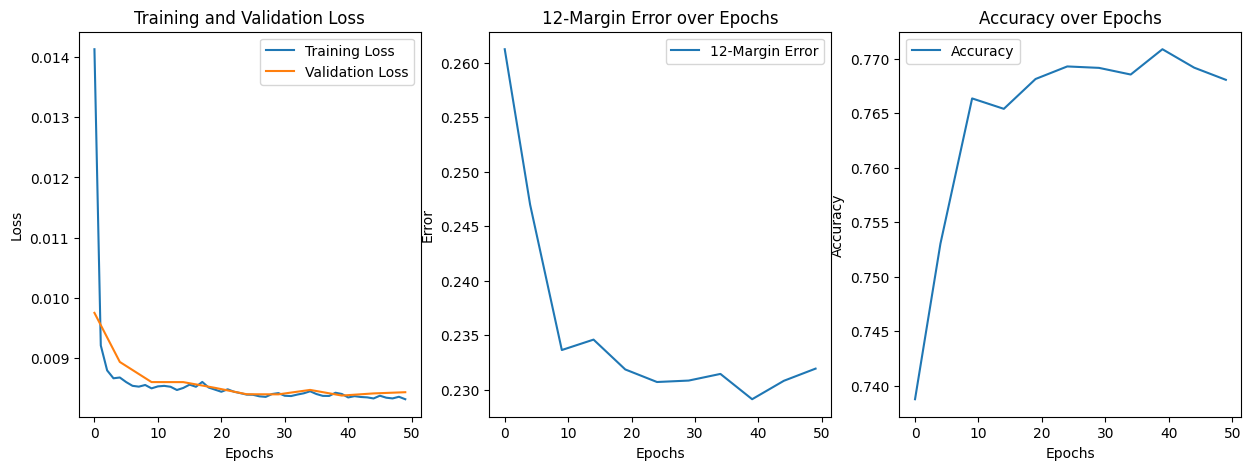

In [ ]:
net2_k2 = Net2(4).to(device)
train_and_evaluate(net2_k2, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0135, Val Loss: 0.0098, 12-Margin Error: 0.2565, Accuracy: 0.7435
Epoch 5, Train Loss: 0.0086, Val Loss: 0.0090, 12-Margin Error: 0.2429, Accuracy: 0.7571
Epoch 10, Train Loss: 0.0084, Val Loss: 0.0086, 12-Margin Error: 0.2355, Accuracy: 0.7645
Epoch 15, Train Loss: 0.0084, Val Loss: 0.0086, 12-Margin Error: 0.2350, Accuracy: 0.7650
Epoch 20, Train Loss: 0.0083, Val Loss: 0.0083, 12-Margin Error: 0.2294, Accuracy: 0.7706
Epoch 25, Train Loss: 0.0084, Val Loss: 0.0086, 12-Margin Error: 0.2363, Accuracy: 0.7637
Epoch 30, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2319, Accuracy: 0.7681
Epoch 35, Train Loss: 0.0083, Val Loss: 0.0083, 12-Margin Error: 0.2271, Accuracy: 0.7729
Epoch 40, Train Loss: 0.0083, Val Loss: 0.0089, 12-Margin Error: 0.2466, Accuracy: 0.7534
Epoch 45, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2306, Accuracy: 0.7694
Early stopping triggered at epoch 50
Epoch 50, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 

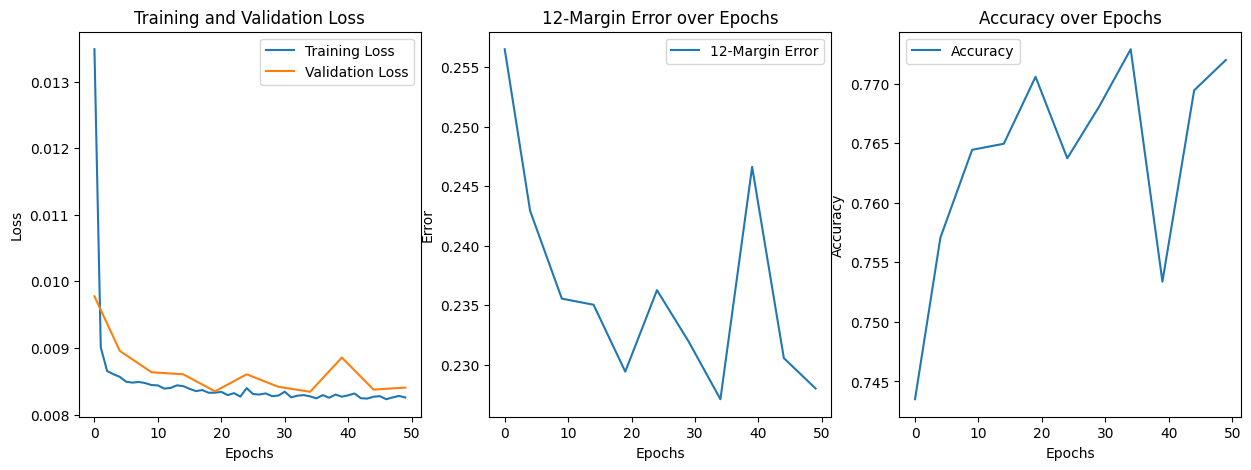

In [ ]:
net2_k3 = Net2(8).to(device)
train_and_evaluate(net2_k3, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0185, Val Loss: 0.0118, 12-Margin Error: 0.3017, Accuracy: 0.6983
Epoch 5, Train Loss: 0.0093, Val Loss: 0.0093, 12-Margin Error: 0.2481, Accuracy: 0.7519
Epoch 10, Train Loss: 0.0086, Val Loss: 0.0087, 12-Margin Error: 0.2368, Accuracy: 0.7632
Epoch 15, Train Loss: 0.0085, Val Loss: 0.0085, 12-Margin Error: 0.2325, Accuracy: 0.7675
Epoch 20, Train Loss: 0.0084, Val Loss: 0.0086, 12-Margin Error: 0.2362, Accuracy: 0.7638
Epoch 25, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2317, Accuracy: 0.7683
Epoch 30, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2305, Accuracy: 0.7695
Epoch 35, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2300, Accuracy: 0.7700
Epoch 40, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2290, Accuracy: 0.7710
Epoch 45, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2299, Accuracy: 0.7701
Early stopping triggered at epoch 50
Epoch 50, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 

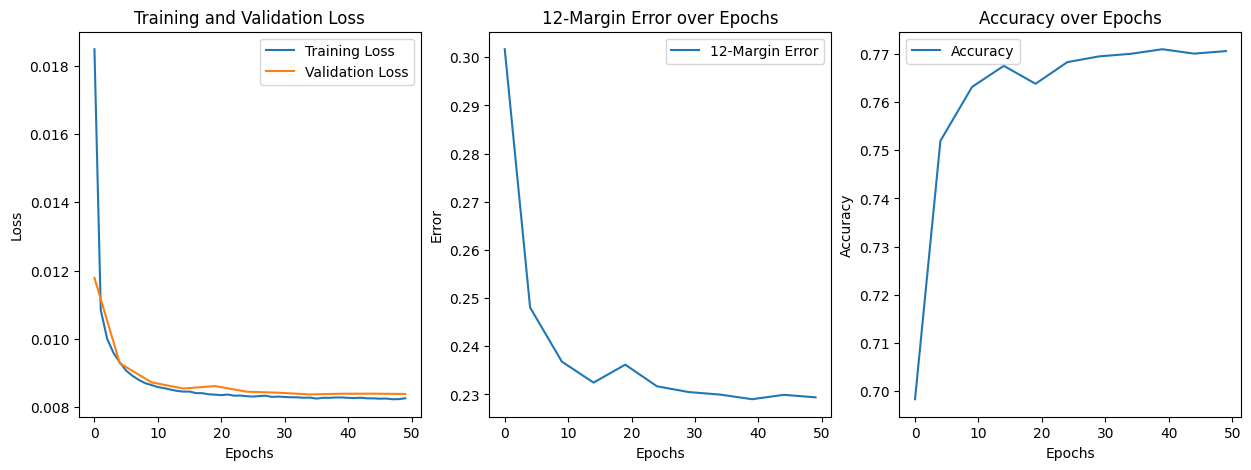

In [ ]:
net2_lr2 = Net2(8).to(device)
train_and_evaluate(net2_lr2, train_loader, val_loader, lr=0.01, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0381, Val Loss: 0.0190, 12-Margin Error: 0.4264, Accuracy: 0.5736
Epoch 5, Train Loss: 0.0135, Val Loss: 0.0134, 12-Margin Error: 0.3311, Accuracy: 0.6689
Epoch 10, Train Loss: 0.0122, Val Loss: 0.0123, 12-Margin Error: 0.3083, Accuracy: 0.6917
Epoch 15, Train Loss: 0.0114, Val Loss: 0.0115, 12-Margin Error: 0.2930, Accuracy: 0.7070
Epoch 20, Train Loss: 0.0109, Val Loss: 0.0110, 12-Margin Error: 0.2825, Accuracy: 0.7175
Epoch 25, Train Loss: 0.0105, Val Loss: 0.0107, 12-Margin Error: 0.2753, Accuracy: 0.7247
Epoch 30, Train Loss: 0.0102, Val Loss: 0.0104, 12-Margin Error: 0.2693, Accuracy: 0.7307
Epoch 35, Train Loss: 0.0100, Val Loss: 0.0101, 12-Margin Error: 0.2648, Accuracy: 0.7352
Epoch 40, Train Loss: 0.0098, Val Loss: 0.0100, 12-Margin Error: 0.2616, Accuracy: 0.7384
Epoch 45, Train Loss: 0.0096, Val Loss: 0.0098, 12-Margin Error: 0.2592, Accuracy: 0.7408
Epoch 50, Train Loss: 0.0095, Val Loss: 0.0097, 12-Margin Error: 0.2565, Accuracy: 0.7435


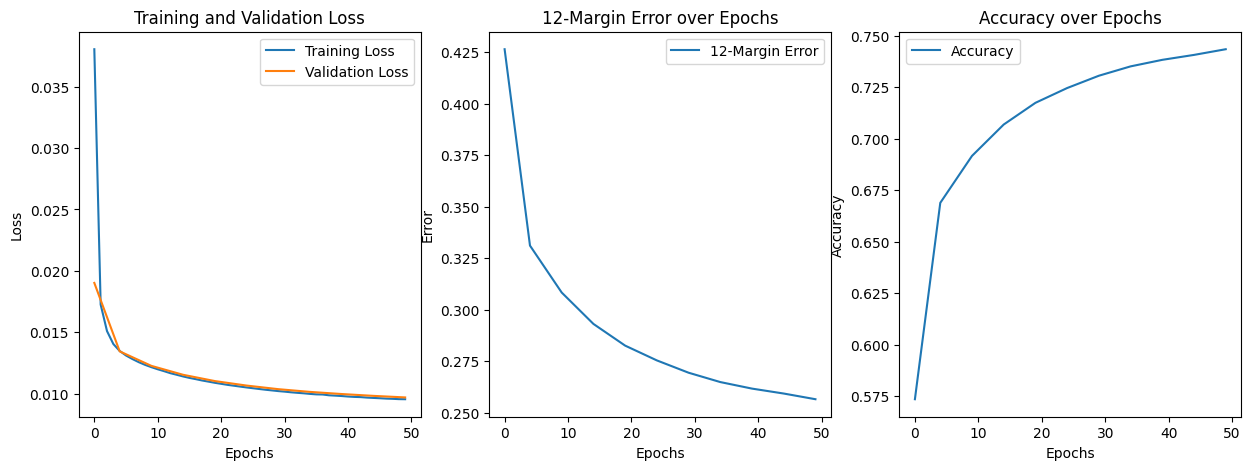

In [ ]:
net2_lr3 = Net2(8).to(device)
train_and_evaluate(net2_lr3, train_loader, val_loader, lr=0.001, max_num_epoch=50, device=device)

In [ ]:
# 2 convolutional layers
class Net2_batchnorm(nn.Module):
    def __init__(self, num_kernels):
        super(Net2_batchnorm, self).__init__()
        self.conv1 = nn.Conv2d(1, num_kernels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_kernels)
        self.conv2 = nn.Conv2d(num_kernels, 3, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(3)

    def forward(self, grayscale_image):
        x = self.conv1(grayscale_image)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x

Epoch 1, Train Loss: 0.0237, Val Loss: 0.0095, 12-Margin Error: 0.2600, Accuracy: 0.7400
Epoch 5, Train Loss: 0.0117, Val Loss: 0.0087, 12-Margin Error: 0.2373, Accuracy: 0.7627
Epoch 10, Train Loss: 0.0117, Val Loss: 0.0132, 12-Margin Error: 0.3730, Accuracy: 0.6270
Epoch 15, Train Loss: 0.0120, Val Loss: 0.0096, 12-Margin Error: 0.2687, Accuracy: 0.7313
Epoch 20, Train Loss: 0.0116, Val Loss: 0.0084, 12-Margin Error: 0.2297, Accuracy: 0.7703
Epoch 25, Train Loss: 0.0114, Val Loss: 0.0089, 12-Margin Error: 0.2478, Accuracy: 0.7522
Epoch 30, Train Loss: 0.0116, Val Loss: 0.0094, 12-Margin Error: 0.2544, Accuracy: 0.7456
Early stopping triggered at epoch 35
Epoch 35, Train Loss: 0.0110, Val Loss: 0.0088, 12-Margin Error: 0.2456, Accuracy: 0.7544


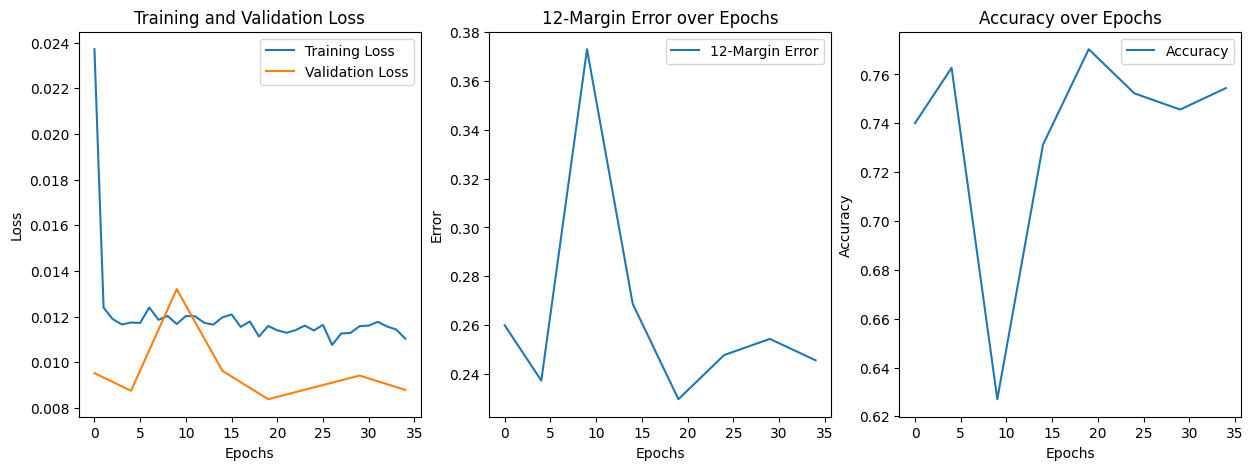

In [ ]:
net2_b = Net2_batchnorm(8).to(device)
train_and_evaluate(net2_b, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

In [ ]:
class Net2_tanh(nn.Module):
    def __init__(self, num_kernels):
        super(Net2_tanh, self).__init__()
        self.conv1 = nn.Conv2d(1, num_kernels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_kernels, 3, 3, padding=1)

    def forward(self, grayscale_image):
        x = F.relu(self.conv1(grayscale_image))
        x = self.conv2(x)
        x = torch.tanh(x)
        return x


Epoch 1, Train Loss: 0.0128, Val Loss: 0.0098, 12-Margin Error: 0.2627, Accuracy: 0.7373
Epoch 5, Train Loss: 0.0085, Val Loss: 0.0086, 12-Margin Error: 0.2350, Accuracy: 0.7650
Epoch 10, Train Loss: 0.0084, Val Loss: 0.0085, 12-Margin Error: 0.2316, Accuracy: 0.7684
Epoch 15, Train Loss: 0.0084, Val Loss: 0.0086, 12-Margin Error: 0.2348, Accuracy: 0.7652
Epoch 20, Train Loss: 0.0083, Val Loss: 0.0085, 12-Margin Error: 0.2306, Accuracy: 0.7694
Epoch 25, Train Loss: 0.0083, Val Loss: 0.0085, 12-Margin Error: 0.2316, Accuracy: 0.7684
Epoch 30, Train Loss: 0.0083, Val Loss: 0.0083, 12-Margin Error: 0.2285, Accuracy: 0.7715
Epoch 35, Train Loss: 0.0083, Val Loss: 0.0085, 12-Margin Error: 0.2341, Accuracy: 0.7659
Epoch 40, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2289, Accuracy: 0.7711
Epoch 45, Train Loss: 0.0083, Val Loss: 0.0083, 12-Margin Error: 0.2292, Accuracy: 0.7708
Epoch 50, Train Loss: 0.0083, Val Loss: 0.0084, 12-Margin Error: 0.2328, Accuracy: 0.7672


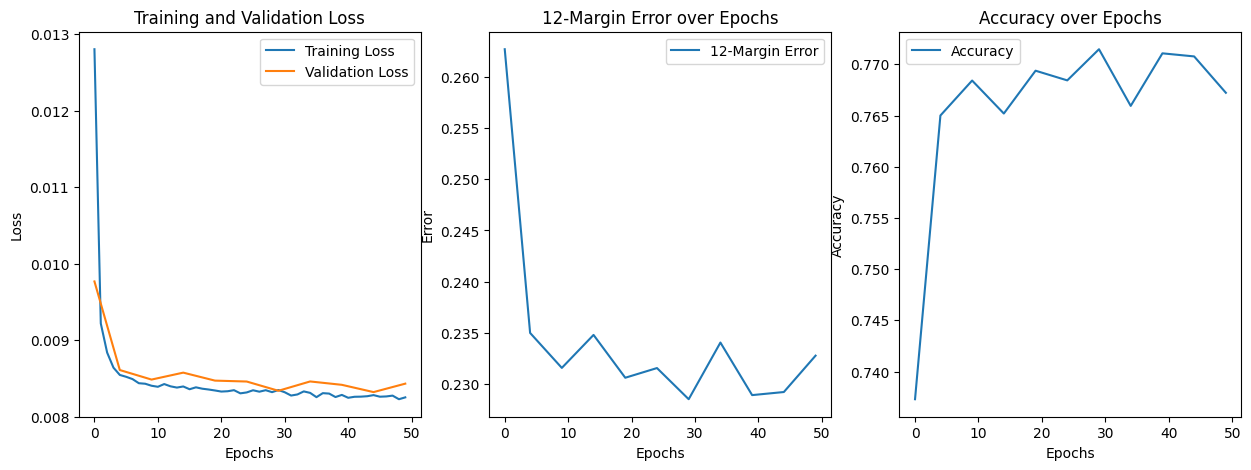

In [ ]:
net2_t = Net2_tanh(8).to(device)
train_and_evaluate(net2_t, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)

Epoch 1, Train Loss: 0.0136, Val Loss: 0.0093, 12-Margin Error: 0.2484, Accuracy: 0.7516
Epoch 5, Train Loss: 0.0084, Val Loss: 0.0085, 12-Margin Error: 0.2351, Accuracy: 0.7649
Epoch 10, Train Loss: 0.0082, Val Loss: 0.0084, 12-Margin Error: 0.2300, Accuracy: 0.7700
Epoch 15, Train Loss: 0.0082, Val Loss: 0.0084, 12-Margin Error: 0.2294, Accuracy: 0.7706
Epoch 20, Train Loss: 0.0082, Val Loss: 0.0082, 12-Margin Error: 0.2259, Accuracy: 0.7741
Epoch 25, Train Loss: 0.0082, Val Loss: 0.0089, 12-Margin Error: 0.2398, Accuracy: 0.7602
Epoch 30, Train Loss: 0.0081, Val Loss: 0.0081, 12-Margin Error: 0.2244, Accuracy: 0.7756
Epoch 35, Train Loss: 0.0081, Val Loss: 0.0081, 12-Margin Error: 0.2236, Accuracy: 0.7764
Epoch 40, Train Loss: 0.0082, Val Loss: 0.0082, 12-Margin Error: 0.2264, Accuracy: 0.7736
Epoch 45, Train Loss: 0.0081, Val Loss: 0.0081, 12-Margin Error: 0.2223, Accuracy: 0.7777
Epoch 50, Train Loss: 0.0081, Val Loss: 0.0081, 12-Margin Error: 0.2228, Accuracy: 0.7772


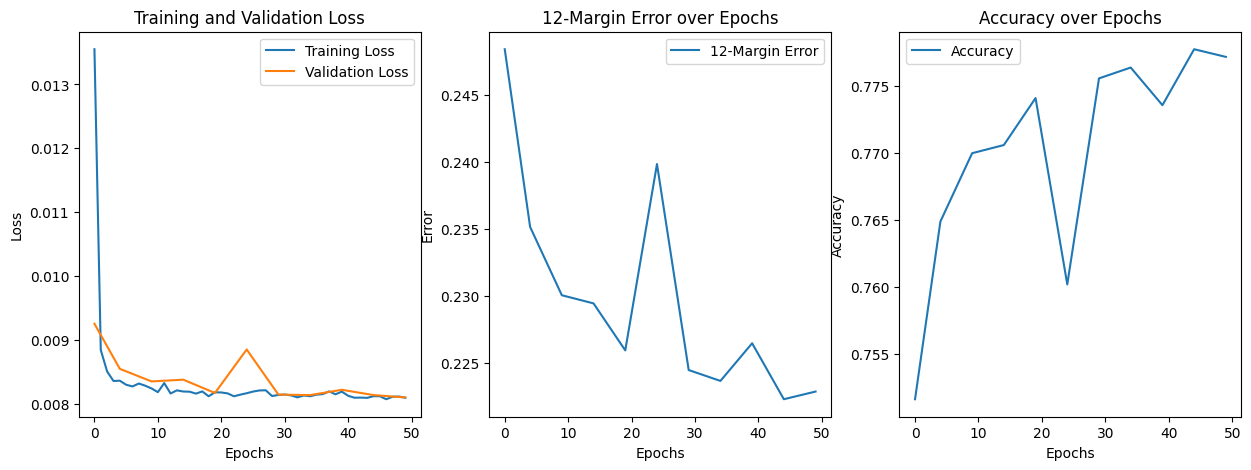

In [ ]:
net2_16 = Net2(16).to(device)
train_and_evaluate(net2_16, train_loader, val_loader, lr=0.1, max_num_epoch=50, device=device)